In [ ]:
!pip install yfinance

In [ ]:
# IMPORTS
import numpy as np
import pandas as pd

#Fin Data Sources
import yfinance as yf
import pandas_datareader as pdr

#Data viz
import plotly.graph_objs as go
import plotly.express as px

import time
from datetime import datetime, timedelta, date

# for graphs
import matplotlib.pyplot as plt

import re
import requests
from tqdm import tqdm

import warnings

# Turn off all warnings
warnings.filterwarnings("ignore")

In [ ]:
headers = {
    'User-Agent': 'Mozilla/5.0 (Windows NT 10.0; Win64; x64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/58.0.3029.110 Safari/537.3',
}

url = "https://stockanalysis.com/ipos/2023/"
response = requests.get(url, headers=headers)

ipo_dfs = pd.read_html(response.text)

In [ ]:
ipos_2023 = ipo_dfs[0]
ipos_2023.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 154 entries, 0 to 153
Data columns (total 6 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   IPO Date      154 non-null    object
 1   Symbol        154 non-null    object
 2   Company Name  154 non-null    object
 3   IPO Price     154 non-null    object
 4   Current       154 non-null    object
 5   Return        154 non-null    object
dtypes: object(6)
memory usage: 7.3+ KB


In [ ]:
url = "https://stockanalysis.com/ipos/2024/"
response = requests.get(url, headers=headers)

ipo_dfs = pd.read_html(response.text)

In [ ]:
ipos_2024 = ipo_dfs[0]
ipos_2024.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 63 entries, 0 to 62
Data columns (total 6 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   IPO Date      63 non-null     object
 1   Symbol        63 non-null     object
 2   Company Name  63 non-null     object
 3   IPO Price     63 non-null     object
 4   Current       63 non-null     object
 5   Return        63 non-null     object
dtypes: object(6)
memory usage: 3.1+ KB


In [ ]:
stacked_ipos_df = pd.concat([ipos_2024, ipos_2023], ignore_index=True)
stacked_ipos_df['IPO Date'] = pd.to_datetime(stacked_ipos_df['IPO Date'])


# it has some missing values --> use defensive errors='coerce' (if don't have time to crack into the data errors)
#     : pd.to_numeric() function call, which will convert problematic values to NaN.
#     otherwise you'll get a ValueError: Unable to parse string "-" at position 9
stacked_ipos_df['IPO Price'] = pd.to_numeric(stacked_ipos_df['IPO Price'].str.replace('$', ''), errors='coerce')
# not sure why, but need to call it again to transform 'object' to 'float64'
stacked_ipos_df['IPO Price'] = pd.to_numeric(stacked_ipos_df['IPO Price'])

# Convert "Current" column
stacked_ipos_df['Current'] = pd.to_numeric(stacked_ipos_df['Current'].str.replace('$', ''), errors='coerce')

# Convert 'Return' to numeric format (percentage)
stacked_ipos_df['Return'] = pd.to_numeric(stacked_ipos_df['Return'].str.replace('%', ''), errors='coerce') / 100

stacked_ipos_df['Price Increase'] = stacked_ipos_df['Current'] - stacked_ipos_df['IPO Price']

In [ ]:
import plotly.express as px

# Truncate to the first day in the month - for Bar names
stacked_ipos_df['Date_monthly'] = stacked_ipos_df['IPO Date'].dt.to_period('M').dt.to_timestamp()

# Count the number of deals for each month and year
monthly_deals = stacked_ipos_df['Date_monthly'].value_counts().reset_index().sort_values(by='Date_monthly')
monthly_deals.columns = ['Date_monthly', 'Number of Deals']

# Plotting the bar chart using Plotly Express
fig = px.bar(monthly_deals,
             x='Date_monthly',
             y='Number of Deals',
             labels={'Month_Year': 'Month and Year', 'Number of Deals': 'Number of Deals'},
             title='Number of IPO Deals per Month and Year',
             text='Number of Deals'
             )
fig.update_traces(textposition='outside', # Position the text outside the bars
                  textfont=dict(color='black',size=14), # Adjust the font size of the text
                  )
fig.update_layout(title_x=0.5) # Center the title

fig.show()

In [ ]:
reddit = yf.download(tickers = "RDDT",
                     period = "max",
                     interval = "1d")

reddit.tail()

[*********************100%%**********************]  1 of 1 completed


,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2024-04-22,40.880001,42.570000,40.509998,42.040001,42.040001,1486400
2024-04-23,42.070000,44.060001,41.821999,42.820000,42.820000,1956500
2024-04-24,42.660000,43.970001,42.450001,43.150002,43.150002,1384000
2024-04-25,41.639999,42.639999,40.849998,42.450001,42.450001,1485800
2024-04-26,42.980000,46.199001,42.650002,45.430000,45.430000,2751600


<Axes: title={'center': "Reddit's (RDDT) price after the IPO"}, xlabel='Date'>

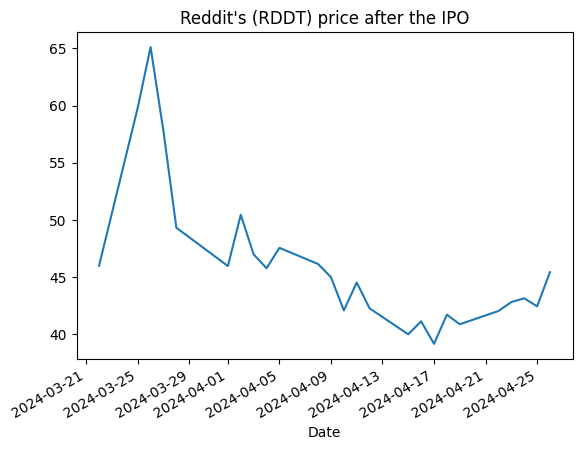

In [ ]:
reddit['Adj Close'].plot.line(title='Reddit\'s (RDDT) price after the IPO')

### Question 1: IPO Filings Web Scraping and Data Processing

**What's the total sum ($m) of 2023 filings that happenned of Fridays?**

Re-use the [Code Snippet 1] example to get the data from web for this endpoint: https://stockanalysis.com/ipos/filings/
Convert the 'Filing Date' to datetime(), 'Shares Offered' to float64 (if '-' is encountered, populate with NaNs).
Define a new field 'Avg_price' based on the "Price Range", which equals to NaN if no price is specified, to the price (if only one number is provided), or to the average of 2 prices (if a range is given).
You may be inspired by the function `extract_numbers()` in [Code Snippet 4], or you can write your own function to "parse" a string.
Define a column "Shares_offered_value", which equals to "Shares Offered" * "Avg_price" (when both columns are defined; otherwise, it's NaN)

Find the total sum in $m (millions of USD, closest INTEGER number) for all fillings during 2023, which happened on Fridays (`Date.dt.dayofweek()==4`). You should see 32 records in total, 24 of it is not null.

(additional: you can read about [S-1 IPO filing](https://www.dfinsolutions.com/knowledge-hub/thought-leadership/knowledge-resources/what-s-1-ipo-filing) to understand the context)

In [ ]:
headers = {
    'User-Agent': 'Mozilla/5.0 (Windows NT 10.0; Win64; x64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/58.0.3029.110 Safari/537.3',
}

url = "https://stockanalysis.com/ipos/filings/"
response = requests.get(url, headers=headers)

ipo_dfs = pd.read_html(response.text)

In [ ]:
df=ipo_dfs[0]
df

,Filing Date,Symbol,Company Name,Price Range,Shares Offered
0,"Apr 26, 2024",EURK,Eureka Acquisition Corp,$10.00,5000000
1,"Apr 26, 2024",HDL,Super Hi International Holding Ltd.,-,-
2,"Apr 22, 2024",DRJT,Derun Group Inc,$5.00,-
3,"Apr 19, 2024",GPAT,GP-Act III Acquisition Corp.,$10.00,25000000
4,"Apr 16, 2024",JLJT,Jialiang Holdings Ltd,$5.00,-
...,...,...,...,...,...
324,"Jan 21, 2020",GOXS,"Goxus, Inc.",$8.00 - $10.00,1500000
325,"Jan 21, 2020",UTXO,"UTXO Acquisition, Inc.",$10.00,5000000
326,"Dec 9, 2019",LOHA,Loha Co. Ltd,$8.00 - $10.00,2500000
327,"Oct 4, 2019",ZGHB,China Eco-Materials Group Co. Limited,$4.00,4300000


In [ ]:
# Convert 'Filing Date' to datetime
df['Filing Date'] = pd.to_datetime(df['Filing Date'])
# Convert 'Shares Offered' to float64, replacing '-' with NaNs
df['Shares Offered'] = pd.to_numeric(df['Shares Offered'], errors='coerce')

In [ ]:
df

,Filing Date,Symbol,Company Name,Price Range,Shares Offered
0,2024-04-26,EURK,Eureka Acquisition Corp,$10.00,5000000.0
1,2024-04-26,HDL,Super Hi International Holding Ltd.,-,NaN
2,2024-04-22,DRJT,Derun Group Inc,$5.00,NaN
3,2024-04-19,GPAT,GP-Act III Acquisition Corp.,$10.00,25000000.0
4,2024-04-16,JLJT,Jialiang Holdings Ltd,$5.00,NaN
...,...,...,...,...,...
324,2020-01-21,GOXS,"Goxus, Inc.",$8.00 - $10.00,1500000.0
325,2020-01-21,UTXO,"UTXO Acquisition, Inc.",$10.00,5000000.0
326,2019-12-09,LOHA,Loha Co. Ltd,$8.00 - $10.00,2500000.0
327,2019-10-04,ZGHB,China Eco-Materials Group Co. Limited,$4.00,4300000.0


In [ ]:
def extract_numbers(input_string):
    matches = re.findall(r'\d+\.\d+', input_string)
    if not matches:
        return float('nan')
    elif len(matches) == 1:
        return float(matches[0])
    else:
        return (float(matches[0]) + float(matches[1])) / 2

In [ ]:
df['Avg_price'] = df['Price Range'].apply(extract_numbers)
df

,Filing Date,Symbol,Company Name,Price Range,Shares Offered,Avg_price
0,2024-04-26,EURK,Eureka Acquisition Corp,$10.00,5000000.0,10.00
1,2024-04-26,HDL,Super Hi International Holding Ltd.,-,NaN,NaN
2,2024-04-22,DRJT,Derun Group Inc,$5.00,NaN,5.00
3,2024-04-19,GPAT,GP-Act III Acquisition Corp.,$10.00,25000000.0,10.00
4,2024-04-16,JLJT,Jialiang Holdings Ltd,$5.00,NaN,5.00
...,...,...,...,...,...,...
324,2020-01-21,GOXS,"Goxus, Inc.",$8.00 - $10.00,1500000.0,9.00
325,2020-01-21,UTXO,"UTXO Acquisition, Inc.",$10.00,5000000.0,10.00
326,2019-12-09,LOHA,Loha Co. Ltd,$8.00 - $10.00,2500000.0,9.00
327,2019-10-04,ZGHB,China Eco-Materials Group Co. Limited,$4.00,4300000.0,4.00


In [ ]:
df['Shares_offered_value'] = df['Shares Offered'] * df['Avg_price']
df

,Filing Date,Symbol,Company Name,Price Range,Shares Offered,Avg_price,Shares_offered_value
0,2024-04-26,EURK,Eureka Acquisition Corp,$10.00,5000000.0,10.00,50000000.0
1,2024-04-26,HDL,Super Hi International Holding Ltd.,-,NaN,NaN,NaN
2,2024-04-22,DRJT,Derun Group Inc,$5.00,NaN,5.00,NaN
3,2024-04-19,GPAT,GP-Act III Acquisition Corp.,$10.00,25000000.0,10.00,250000000.0
4,2024-04-16,JLJT,Jialiang Holdings Ltd,$5.00,NaN,5.00,NaN
...,...,...,...,...,...,...,...
324,2020-01-21,GOXS,"Goxus, Inc.",$8.00 - $10.00,1500000.0,9.00,13500000.0
325,2020-01-21,UTXO,"UTXO Acquisition, Inc.",$10.00,5000000.0,10.00,50000000.0
326,2019-12-09,LOHA,Loha Co. Ltd,$8.00 - $10.00,2500000.0,9.00,22500000.0
327,2019-10-04,ZGHB,China Eco-Materials Group Co. Limited,$4.00,4300000.0,4.00,17200000.0


In [ ]:
fridays_df

,Filing Date,Symbol,Company Name,Price Range,Shares Offered,Avg_price,Shares_offered_value
52,2023-12-29,LEC,Lafayette Energy Corp,$3.50 - $4.50,1200000.0,4.00,4800000.0
53,2023-12-29,EPSM,Epsium Enterprise Limited,-,NaN,NaN,NaN
56,2023-12-22,LZMH,LZ Technology Holdings Limited,-,NaN,NaN,NaN
57,2023-12-22,CHLW,Chun Hui Le Wan International Holding Group Ltd,-,NaN,NaN,NaN
62,2023-12-15,GIT,Going International Holding Company Limited,-,NaN,NaN,NaN
64,2023-12-08,ENGS,Energys Group Limited,$4.00 - $6.00,2000000.0,5.00,10000000.0
65,2023-12-08,LNKS,Linkers Industries Limited,$4.00 - $6.00,2200000.0,5.00,11000000.0
86,2023-10-27,RAY,Raytech Holding Limited,$4.00 - $5.00,1500000.0,4.50,6750000.0
93,2023-10-13,ORIS,Oriental Rise Holdings Limited,$4.00,2000000.0,4.00,8000000.0
96,2023-10-06,QMMM,QMMM Holdings Limited,$4.00,2125000.0,4.00,8500000.0


In [ ]:
filtered_df = df[df['Filing Date'].dt.year == 2023]

fridays_df = filtered_df[filtered_df['Filing Date'].dt.dayofweek == 4]

agg_df = fridays_df.groupby(fridays_df['Filing Date'].dt.strftime('%Y-%m-%d')).agg({'Shares_offered_value': 'sum'}).reset_index()

agg_df['Shares_offered_value'] = agg_df['Shares_offered_value'] / 1e6

agg_df.rename(columns={ 'Shares_offered_value': 'Total_sum_$m'}, inplace=True)

agg_df

,Filing Date,Total_sum_$m
0,2023-01-13,16.875
1,2023-02-10,35.000
2,2023-02-24,62.500
3,2023-03-24,0.000
4,2023-03-31,37.375
5,2023-04-21,16.000
6,2023-04-28,11.250
7,2023-06-09,10.000
8,2023-06-23,0.000
9,2023-06-30,14.075


In [ ]:
agg_df['Total_sum_$m'].sum()

275.95

### Question 2:  IPOs "Fixed days hold" strategy


**Find the optimal number of days X (between 1 and 30), where 75% quantile growth is the highest?**


Reuse [Code Snippet 1] to retrieve the list of IPOs from 2023 and 2024 (from URLs: https://stockanalysis.com/ipos/2023/ and https://stockanalysis.com/ipos/2024/). Get all OHLCV daily prices for all stocks with an "IPO date" before March 1, 2024 ("< 2024-03-01") - 185 tickers. Sometimes you may need to adjust the symbol name (e.g., 'IBAC' on stockanalysis.com -> 'IBACU' on Yahoo Finance) to locate OHLCV(Open High Low Close Volume) prices for all stocks.

Let's assume you managed to buy a new stock (listed on IPO) on the first day at the [Adj Close] price]. Your strategy is to hold for exactly X full days (where X is between 1 and 30) and sell at the "Adj. Close" price in X days (e.g., if X=1, you sell on the next day).
Find X, when the 75% quantile growth (among 185 investments) is the highest.

HINTs:
* You can generate 30 additional columns: growth_future_1d ... growth_future_30d, join that with the table of min_dates (first day when each stock has data on Yahoo Finance), and perform vector operations on the resulting dataset.
* You can use the `DataFrame.describe()` function to get mean, min, max, 25-50-75% quantiles.


Addtional:
* You can also ensure that the mean and 50th percentile (median) investment returns are negative for most X values, implying a wager for a "lucky" investor who might be in the top 25%.
* What's your recommendation: Do you suggest pursuing this strategy for an optimal X?

In [ ]:
headers = {
    'User-Agent': 'Mozilla/5.0 (Windows NT 10.0; Win64; x64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/58.0.3029.110 Safari/537.3',
}
url = "https://stockanalysis.com/ipos/2023/"
response = requests.get(url, headers=headers)

ipo_dfs = pd.read_html(response.text)
ipos_2023 = ipo_dfs[0]

url = "https://stockanalysis.com/ipos/2024/"
response = requests.get(url, headers=headers)

ipo_dfs = pd.read_html(response.text)
ipos_2024 = ipo_dfs[0]

stacked_ipos_df = pd.concat([ipos_2024, ipos_2023], ignore_index=True)
stacked_ipos_df['IPO Date'] = pd.to_datetime(stacked_ipos_df['IPO Date'])
ipo_df=stacked_ipos_df
ipo_df=ipo_df[ipo_df['IPO Date'] < '2024-03-01']
ipo_df

,IPO Date,Symbol,Company Name,IPO Price,Current,Return
32,2024-02-27,SMXT,"SolarMax Technology, Inc.",$4.00,$10.50,162.50%
33,2024-02-22,VHAI,Vocodia Holdings Corp,$4.25,$0.18,-95.68%
34,2024-02-21,DYCQ,DT Cloud Acquisition Corporation,$10.00,$10.12,1.20%
35,2024-02-16,CHRO,Chromocell Therapeutics Corp,$6.00,$1.60,-73.33%
36,2024-02-14,UMAC,"Unusual Machines, Inc.",$4.00,$1.42,-64.50%
...,...,...,...,...,...,...
212,2023-01-25,QSG,QuantaSing Group Ltd,$12.50,$3.43,-72.56%
213,2023-01-20,CVKD,"Cadrenal Therapeutics, Inc.",$5.00,$0.43,-91.39%
214,2023-01-13,SKWD,"Skyward Specialty Insurance Group, Inc.",$15.00,$33.46,123.07%
215,2023-01-13,ISRL,Israel Acquisitions Corp,$10.00,$10.92,9.20%


In [ ]:
syms=ipo_df.Symbol.unique().tolist()

In [ ]:
def load_prep_slice(ticker,num_day):
    df= yf.download(tickers = ticker,
                     period = "max",
                     interval = "1d")

    for i in range(1, num_day + 1):
        column_name = f'growth_future_{i}d'
        df[column_name] = df['Adj Close'].shift(-i) / df['Adj Close']


    df['Symbol']=ticker
    df=df.iloc[[0]]
    df.reset_index(inplace=True)
    df.rename(columns={'Date': 'IPO Date'}, inplace=True)
    return df

In [ ]:
load_prep_slice('JYD',30)

[*********************100%%**********************]  1 of 1 completed


,IPO Date,Open,High,Low,Close,Adj Close,Volume,growth_future_1d,growth_future_2d,growth_future_3d,...,growth_future_22d,growth_future_23d,growth_future_24d,growth_future_25d,growth_future_26d,growth_future_27d,growth_future_28d,growth_future_29d,growth_future_30d,Symbol
0,2023-04-24,4.06,4.58,3.69,4.07,4.07,1542600,0.859951,0.859459,0.916462,...,0.791155,0.774201,0.724816,0.739558,0.727273,0.77887,0.832924,0.784521,0.810811,JYD


In [ ]:
full=[]
for symbol in tqdm(syms):
  try:
    df=load_prep_slice(symbol,30)
    ipo=ipo_df[ipo_df['Symbol'] == symbol]
    merged_df = pd.merge(df,ipo, on=['IPO Date', 'Symbol'], how='inner')
    full.append(merged_df)
  except:
    pass
full_df= pd.concat(full)

[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%*******

In [ ]:
summary_stats_df = full_df.describe()

In [ ]:
summary_stats_df

,IPO Date,Open,High,Low,Close,Adj Close,Volume,growth_future_1d,growth_future_2d,growth_future_3d,...,growth_future_21d,growth_future_22d,growth_future_23d,growth_future_24d,growth_future_25d,growth_future_26d,growth_future_27d,growth_future_28d,growth_future_29d,growth_future_30d
count,120,120.000000,120.000000,120.000000,120.000000,120.000000,1.200000e+02,120.000000,120.000000,120.000000,...,120.000000,120.000000,120.000000,120.000000,120.000000,120.000000,120.000000,120.000000,120.000000,120.000000
mean,2023-08-01 18:36:00,20.136917,78.404646,18.315996,48.775062,48.700154,5.575380e+06,0.930677,0.923854,0.918302,...,0.912845,0.905820,0.899498,0.889359,0.879697,0.880632,0.862203,0.867587,0.865668,0.859417
min,2023-01-13 00:00:00,0.400000,0.514500,0.377500,0.397500,0.397500,3.519100e+04,0.153569,0.108733,0.086641,...,0.048326,0.048326,0.049361,0.048326,0.048326,0.045219,0.044529,0.046945,0.042803,0.040387
25%,2023-04-02 06:00:00,4.175000,5.210000,3.477500,4.017500,4.017500,9.077000e+05,0.863174,0.812335,0.811673,...,0.561959,0.539413,0.545130,0.537206,0.552353,0.548026,0.542212,0.541469,0.520169,0.533878
50%,2023-07-26 00:00:00,6.175000,8.700000,5.020000,6.175000,6.175000,2.020500e+06,0.977273,0.984013,0.976391,...,0.933248,0.947450,0.931171,0.908122,0.898215,0.876021,0.872874,0.887863,0.884373,0.891651
75%,2023-11-14 18:00:00,15.670000,18.300000,15.000000,15.380000,15.167089,4.712875e+06,1.021444,1.025277,1.019831,...,1.044778,1.050277,1.045944,1.067374,1.057243,1.062728,1.058672,1.063277,1.066245,1.072579
max,2024-02-27 00:00:00,810.000000,7500.000000,810.000000,4318.000000,4318.000000,1.305345e+08,1.362069,1.464015,2.380000,...,4.500000,3.871041,3.846154,3.803394,3.427273,4.817886,4.434146,4.570732,4.247155,3.629268
std,NaN,75.859451,683.797145,74.977498,393.445136,393.448261,1.440403e+07,0.186082,0.228188,0.283042,...,0.585851,0.543684,0.546267,0.537508,0.537065,0.591143,0.551214,0.553029,0.528943,0.489995


In [ ]:
def get_stat_result(stat_value):
  row = summary_stats_df.loc[stat_value]
  growth_columns = [f"growth_future_{i}d" for i in range(1, 31)]
  growth = row[growth_columns]
  growth_numeric = pd.to_numeric(growth, errors='coerce')
  max_growth_column = growth_numeric.idxmax()
  max_growth_value = growth_numeric[max_growth_column]
  print(f"The growth column with the maximum value at {stat_value} is: {max_growth_column}, with a value of: {max_growth_value}")

In [ ]:
get_stat_result('75%')

The growth column with the maximum value at 75% is: growth_future_30d, with a value of: 1.0725790369905925


In [ ]:
get_stat_result('mean')

The growth column with the maximum value at mean is: growth_future_12d, with a value of: 0.9317100412037022


In [ ]:
get_stat_result('50%')

The growth column with the maximum value at 50% is: growth_future_2d, with a value of: 0.9840131113626926


#### Implying a wager for a "lucky" investor who might land in the top 25%, this strategy proves impractical for profiting by purchasing IPOs at their closing prices on the first day

### Question 3: Is Growth Concentrated in the Largest Stocks?

**Get the share of days (percentage as int) when Large Stocks outperform (growth_7d - growth over 7 periods back) the Largest stocks?**


Reuse [Code Snippet 5] to obtain OHLCV stats for 33 stocks
for 10 full years of data (2014-01-01 to 2023-12-31). You'll need to download slightly more data (7 periods before 2014-01-01 to calculate the growth_7d for the first 6 days correctly):

`US_STOCKS = ['MSFT', 'AAPL', 'GOOG', 'NVDA', 'AMZN', 'META', 'BRK-B', 'LLY', 'AVGO','V', 'JPM']`

`EU_STOCKS = ['NVO','MC.PA', 'ASML', 'RMS.PA', 'OR.PA', 'SAP', 'ACN', 'TTE', 'SIE.DE','IDEXY','CDI.PA']`

`INDIA_STOCKS = ['RELIANCE.NS','TCS.NS','HDB','BHARTIARTL.NS','IBN','SBIN.NS','LICI.NS','INFY','ITC.NS','HINDUNILVR.NS','LT.NS']`

`LARGEST_STOCKS = US_STOCKS + EU_STOCKS + INDIA_STOCKS`
<br/>

Now let's add the top 12-22 stocks (as of end-April 2024):
<br/>

`NEW_US = ['TSLA','WMT','XOM','UNH','MA','PG','JNJ','MRK','HD','COST','ORCL']`

`NEW_EU = ['PRX.AS','CDI.PA','AIR.PA','SU.PA','ETN','SNY','BUD','DTE.DE','ALV.DE','MDT','AI.PA','EL.PA']`

`NEW_INDIA = ['BAJFINANCE.NS','MARUTI.NS','HCLTECH.NS','TATAMOTORS.NS','SUNPHARMA.NS','ONGC.NS','ADANIENT.NS','ADANIENT.NS','NTPC.NS','KOTAKBANK.NS','TITAN.NS']`

`LARGE_STOCKS = NEW_EU + NEW_US + NEW_INDIA`

You should be able to obtain stats for 33 LARGEST STOCKS and 32 LARGE STOCKS (from the actual stats on Yahoo Finance)

Calculate  `growth_7d` for every stock and every day.
Get the average daily `growth_7d` for the LARGEST_STOCKS group vs. the LARGE_STOCKS group.

For example, for the first of data you should have:
| Date   |      ticker_category      |  growth_7d |
|----------|:-------------:|------:|
| 2014-01-01 |  LARGE | 1.011684 |
| 2014-01-01 |   LARGEST   |   1.011797 |

On that day, the LARGEST group was growing faster than LARGE one (new stocks).

Calculate the number of days when the LARGE GROUP (new smaller stocks) outperforms the LARGEST GROUP, divide it by the total number of trading days (which should be 2595 days), and convert it to a percentage (closest INTEGER value). For example, if you find that 1700 out of 2595 days meet this condition, it means that 1700/2595 = 0.655, or approximately 66% of days, the LARGE stocks were growing faster than the LARGEST ones. This suggests that you should consider extending your dataset with more stocks to seek higher growth.

HINT: you can use pandas.pivot_table() to "flatten" the table (LARGE and LARGEST growth_7d as columns)

In [ ]:
US_STOCKS = ['MSFT', 'AAPL', 'GOOG', 'NVDA', 'AMZN', 'META', 'BRK-B', 'LLY', 'AVGO','V', 'JPM']

EU_STOCKS = ['NVO','MC.PA', 'ASML', 'RMS.PA', 'OR.PA', 'SAP', 'ACN', 'TTE', 'SIE.DE','IDEXY','CDI.PA']

INDIA_STOCKS = ['RELIANCE.NS','TCS.NS','HDB','BHARTIARTL.NS','IBN','SBIN.NS','LICI.NS','INFY','ITC.NS','HINDUNILVR.NS','LT.NS']

LARGEST_STOCKS = US_STOCKS + EU_STOCKS + INDIA_STOCKS

In [ ]:
NEW_US = ['TSLA','WMT','XOM','UNH','MA','PG','JNJ','MRK','HD','COST','ORCL']

NEW_EU = ['PRX.AS','CDI.PA','AIR.PA','SU.PA','ETN','SNY','BUD','DTE.DE','ALV.DE','MDT','AI.PA','EL.PA']

NEW_INDIA = ['BAJFINANCE.NS','MARUTI.NS','HCLTECH.NS','TATAMOTORS.NS','SUNPHARMA.NS','ONGC.NS','ADANIENT.NS','ADANIENT.NS','NTPC.NS','KOTAKBANK.NS','TITAN.NS']

LARGE_STOCKS = NEW_EU + NEW_US + NEW_INDIA

In [ ]:
start_date = '2013-12-20'  # buffer days before 2014-01-01
end_date = '2023-12-31'

In [ ]:
def retrieve_price(ALL_TICKERS,start_date,end_date):
    stocks_df = pd.DataFrame({'A' : []})

    for i,ticker in enumerate(ALL_TICKERS):
        print(i,ticker)

        # Work with stock prices
        historyPrices = yf.download(tickers = ticker,
                          start=start_date,
                          end=end_date,
                          interval = "1d")

        # generate features for historical prices, and what we want to predict
        historyPrices['Ticker'] = ticker
        historyPrices['Date'] = historyPrices.index.date

        # historical returns
        historyPrices['growth_7d'] = historyPrices['Adj Close'] / historyPrices['Adj Close'].shift(7)


        # sleep 1 sec between downloads - not to overload the API server
        time.sleep(1)


        if stocks_df.empty:
          stocks_df = historyPrices
        else:
          stocks_df = pd.concat([stocks_df, historyPrices], ignore_index=True)
    return stocks_df

In [ ]:
largest=retrieve_price(LARGEST_STOCKS,start_date,end_date)
largest_group = largest.groupby('Date')['growth_7d'].mean().reset_index()
largest_group['Date'] = pd.to_datetime(largest_group['Date'])
largest_group= largest_group[largest_group['Date'] >= '2014-01-01']
largest_group['ticker_category'] = 'LARGEST'

0 MSFT


[*********************100%%**********************]  1 of 1 completed


1 AAPL


[*********************100%%**********************]  1 of 1 completed


2 GOOG


[*********************100%%**********************]  1 of 1 completed


3 NVDA


[*********************100%%**********************]  1 of 1 completed


4 AMZN


[*********************100%%**********************]  1 of 1 completed


5 META


[*********************100%%**********************]  1 of 1 completed


6 BRK-B


[*********************100%%**********************]  1 of 1 completed


7 LLY


[*********************100%%**********************]  1 of 1 completed


8 AVGO


[*********************100%%**********************]  1 of 1 completed


9 V


[*********************100%%**********************]  1 of 1 completed


10 JPM


[*********************100%%**********************]  1 of 1 completed


11 NVO


[*********************100%%**********************]  1 of 1 completed


12 MC.PA


[*********************100%%**********************]  1 of 1 completed


13 ASML


[*********************100%%**********************]  1 of 1 completed


14 RMS.PA


[*********************100%%**********************]  1 of 1 completed


15 OR.PA


[*********************100%%**********************]  1 of 1 completed


16 SAP


[*********************100%%**********************]  1 of 1 completed


17 ACN


[*********************100%%**********************]  1 of 1 completed


18 TTE


[*********************100%%**********************]  1 of 1 completed


19 SIE.DE


[*********************100%%**********************]  1 of 1 completed


20 IDEXY


[*********************100%%**********************]  1 of 1 completed


21 CDI.PA


[*********************100%%**********************]  1 of 1 completed


22 RELIANCE.NS


[*********************100%%**********************]  1 of 1 completed


23 TCS.NS


[*********************100%%**********************]  1 of 1 completed


24 HDB


[*********************100%%**********************]  1 of 1 completed


25 BHARTIARTL.NS


[*********************100%%**********************]  1 of 1 completed


26 IBN


[*********************100%%**********************]  1 of 1 completed


27 SBIN.NS


[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed

28 LICI.NS


29 INFY


[*********************100%%**********************]  1 of 1 completed


30 ITC.NS


[*********************100%%**********************]  1 of 1 completed


31 HINDUNILVR.NS


[*********************100%%**********************]  1 of 1 completed


32 LT.NS


[*********************100%%**********************]  1 of 1 completed


In [ ]:
large=retrieve_price(LARGE_STOCKS,start_date,end_date)
large_group = large.groupby('Date')['growth_7d'].mean().reset_index()
large_group['Date'] = pd.to_datetime(large_group['Date'])
large_group= large_group[large_group['Date'] >= '2014-01-01']
large_group['ticker_category'] = 'LARGE'

0 PRX.AS


[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed

1 CDI.PA


2 AIR.PA


[*********************100%%**********************]  1 of 1 completed


3 SU.PA


[*********************100%%**********************]  1 of 1 completed


4 ETN


[*********************100%%**********************]  1 of 1 completed


5 SNY


[*********************100%%**********************]  1 of 1 completed


6 BUD


[*********************100%%**********************]  1 of 1 completed


7 DTE.DE


[*********************100%%**********************]  1 of 1 completed


8 ALV.DE


[*********************100%%**********************]  1 of 1 completed


9 MDT


[*********************100%%**********************]  1 of 1 completed


10 AI.PA


[*********************100%%**********************]  1 of 1 completed


11 EL.PA


[*********************100%%**********************]  1 of 1 completed


12 TSLA


[*********************100%%**********************]  1 of 1 completed


13 WMT


[*********************100%%**********************]  1 of 1 completed


14 XOM


[*********************100%%**********************]  1 of 1 completed


15 UNH


[*********************100%%**********************]  1 of 1 completed


16 MA


[*********************100%%**********************]  1 of 1 completed


17 PG


[*********************100%%**********************]  1 of 1 completed


18 JNJ


[*********************100%%**********************]  1 of 1 completed


19 MRK


[*********************100%%**********************]  1 of 1 completed


20 HD


[*********************100%%**********************]  1 of 1 completed


21 COST


[*********************100%%**********************]  1 of 1 completed


22 ORCL


[*********************100%%**********************]  1 of 1 completed


23 BAJFINANCE.NS


[*********************100%%**********************]  1 of 1 completed


24 MARUTI.NS


[*********************100%%**********************]  1 of 1 completed


25 HCLTECH.NS


[*********************100%%**********************]  1 of 1 completed


26 TATAMOTORS.NS


[*********************100%%**********************]  1 of 1 completed


27 SUNPHARMA.NS


[*********************100%%**********************]  1 of 1 completed


28 ONGC.NS


[*********************100%%**********************]  1 of 1 completed


29 ADANIENT.NS


[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed

30 ADANIENT.NS


31 NTPC.NS


[*********************100%%**********************]  1 of 1 completed


32 KOTAKBANK.NS


[*********************100%%**********************]  1 of 1 completed


33 TITAN.NS


[*********************100%%**********************]  1 of 1 completed


In [ ]:
large_group

,Date,growth_7d,ticker_category
7,2014-01-01,1.011684,LARGE
8,2014-01-02,0.997706,LARGE
9,2014-01-03,0.999534,LARGE
10,2014-01-06,0.995876,LARGE
11,2014-01-07,0.991592,LARGE
...,...,...,...
2597,2023-12-22,1.003014,LARGE
2598,2023-12-26,1.013505,LARGE
2599,2023-12-27,1.002167,LARGE
2600,2023-12-28,0.998583,LARGE


In [ ]:
largest_group

,Date,growth_7d,ticker_category
7,2014-01-01,1.011797,LARGEST
8,2014-01-02,1.002964,LARGEST
9,2014-01-03,0.997668,LARGEST
10,2014-01-06,0.993423,LARGEST
11,2014-01-07,0.992509,LARGEST
...,...,...,...
2597,2023-12-22,1.013788,LARGEST
2598,2023-12-26,1.014900,LARGEST
2599,2023-12-27,1.014155,LARGEST
2600,2023-12-28,1.008533,LARGEST


In [ ]:
merged_df = pd.merge(large_group, largest_group, on='Date', suffixes=('_large', '_largest'))
merged_df.drop(['ticker_category_large', 'ticker_category_largest'], axis=1, inplace=True)

In [ ]:
merged_df['large_outperforms'] = merged_df['growth_7d_large'] > merged_df['growth_7d_largest']

In [ ]:
int((merged_df['large_outperforms'].sum() / merged_df.shape[0]) * 100)

47

### Question 4: Trying Another Technical Indicators strategy

**What's the total gross profit (in THOUSANDS of $) you'll get from trading on CCI (no fees assumption)?**


First, run the entire Colab to obtain the full DataFrame of data (after [Code Snippet 9]), and truncate it to the last full 10 years of data (2014-01-01 to 2023-12-31).
If you encounter any difficulties running the Colab - you can download it using this [link](https://drive.google.com/file/d/1m3Qisfs2XfWk6Sw_Uk5kHLWqwQ0q8SKb/view?usp=sharing).

Let's assume you've learned about the awesome **CCI indicator** ([Commodity Channel Index](https://www.investopedia.com/terms/c/commoditychannelindex.asp)), and decided to use only it for your operations.

You defined the "defensive" value of a high threshould of 200, and you trade only on Fridays (`Date.dt.dayofweek()==4`).

That is, every time you see that CCI is >200 for any stock (out of those 33), you'll invest $1000 (each record when CCI>200) at Adj.Close price and hold it for 1 week (5 trading days) in order to sell at the Adj. Close price.

What's the expected gross profit (no fees) that you get in THOUSANDS $ (closest integer value) over many operations in 10 years?
One operation calculations: if you invested $1000 and received $1010 in 5 days - you add $10 to gross profit, if you received $980 - add -$20 to gross profit.
You need to sum these results over all trades (460 times in 10 years).

Additional:
  * Add an approximate fees calculation over the 460 trades from this calculator https://www.degiro.ie/fees/calculator (Product:"Shares, USA and Canada;" Amount per transaction: "1000 EUR"; Transactions per year: "460")
  * are you still profitable on those trades?

In [ ]:
# https://stackoverflow.com/questions/49648391/how-to-install-ta-lib-in-google-colab
# Update (apr 2023): Colab is now Python 3.10
# there are some other (older) ways to install talib

url = 'https://anaconda.org/conda-forge/libta-lib/0.4.0/download/linux-64/libta-lib-0.4.0-h166bdaf_1.tar.bz2'
!curl -L $url | tar xj -C /usr/lib/x86_64-linux-gnu/ lib --strip-components=1
url = 'https://anaconda.org/conda-forge/ta-lib/0.4.19/download/linux-64/ta-lib-0.4.19-py310hde88566_4.tar.bz2'
!curl -L $url | tar xj -C /usr/local/lib/python3.10/dist-packages/ lib/python3.10/site-packages/talib --strip-components=3
import talib

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  4119    0  4119    0     0   7374      0 --:--:-- --:--:-- --:--:--  7381
100  517k  100  517k    0     0   260k      0  0:00:01  0:00:01 --:--:--  445k
  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  4095    0  4095    0     0   9674      0 --:--:-- --:--:-- --:--:--  9680
100  392k  100  392k    0     0   215k      0  0:00:01  0:00:01 --:--:--  404k


6.1) Momentum indicators

In [ ]:
def talib_get_momentum_indicators_for_one_ticker(df: pd.DataFrame) -> pd.DataFrame:
  # ADX - Average Directional Movement Index
  talib_momentum_adx = talib.ADX(df.High.values, df.Low.values, df.Close.values, timeperiod=14)
  # ADXR - Average Directional Movement Index Rating
  talib_momentum_adxr = talib.ADXR(df.High.values, df.Low.values, df.Close.values, timeperiod=14 )
  # APO - Absolute Price Oscillator
  talib_momentum_apo = talib.APO(df.Close.values, fastperiod=12, slowperiod=26, matype=0 )
  # AROON - Aroon
  talib_momentum_aroon = talib.AROON(df.High.values, df.Low.values, timeperiod=14 )
  # talib_momentum_aroon[0].size
  # talib_momentum_aroon[1].size
  # AROONOSC - Aroon Oscillator
  talib_momentum_aroonosc = talib.AROONOSC(df.High.values, df.Low.values, timeperiod=14)
  # BOP - Balance of Power
  # https://school.stockcharts.com/doku.php?id=technical_indicators:balance_of_power
     #calculate open prices as shifted closed prices from the prev day
     # open = df.Last.shift(1)
  talib_momentum_bop = talib.BOP(df.Open.values, df.High.values, df.Low.values, df.Close.values)
  # CCI - Commodity Channel Index
  talib_momentum_cci = talib.CCI(df.High.values, df.Low.values, df.Close.values, timeperiod=14)
  # CMO - Chande Momentum Oscillator
  talib_momentum_cmo = talib.CMO(df.Close.values, timeperiod=14)
  # DX - Directional Movement Index
  talib_momentum_dx = talib.DX(df.High.values, df.Low.values, df.Close.values, timeperiod=14)
  # MACD - Moving Average Convergence/Divergence
  talib_momentum_macd, talib_momentum_macdsignal, talib_momentum_macdhist = talib.MACD(df.Close.values, fastperiod=12, \
                                                                                       slowperiod=26, signalperiod=9)
  # MACDEXT - MACD with controllable MA type
  talib_momentum_macd_ext, talib_momentum_macdsignal_ext, talib_momentum_macdhist_ext = talib.MACDEXT(df.Close.values, \
                                                                                                    fastperiod=12, \
                                                                                                    fastmatype=0, \
                                                                                                    slowperiod=26, \
                                                                                                    slowmatype=0, \
                                                                                                    signalperiod=9, \
                                                                                                  signalmatype=0)
  # MACDFIX - Moving Average Convergence/Divergence Fix 12/26
  talib_momentum_macd_fix, talib_momentum_macdsignal_fix, talib_momentum_macdhist_fix = talib.MACDFIX(df.Close.values, \
                                                                                                      signalperiod=9)
  # MFI - Money Flow Index
  talib_momentum_mfi = talib.MFI(df.High.values, df.Low.values, df.Close.values, df.Volume.values, timeperiod=14)
  # MINUS_DI - Minus Directional Indicator
  talib_momentum_minus_di = talib.MINUS_DM(df.High.values, df.Low.values, timeperiod=14)
  # MOM - Momentum
  talib_momentum_mom = talib.MOM(df.Close.values, timeperiod=10)
  # PLUS_DI - Plus Directional Indicator
  talib_momentum_plus_di = talib.PLUS_DI(df.High.values, df.Low.values, df.Close.values, timeperiod=14)
  # PLUS_DM - Plus Directional Movement
  talib_momentum_plus_dm = talib.PLUS_DM(df.High.values, df.Low.values, timeperiod=14)
  # PPO - Percentage Price Oscillator
  talib_momentum_ppo = talib.PPO(df.Close.values, fastperiod=12, slowperiod=26, matype=0)
  # ROC - Rate of change : ((price/prevPrice)-1)*100
  talib_momentum_roc = talib.ROC(df.Close.values, timeperiod=10)
  # ROCP - Rate of change Percentage: (price-prevPrice)/prevPrice
  talib_momentum_rocp = talib.ROCP(df.Close.values, timeperiod=10)
  # ROCR - Rate of change ratio: (price/prevPrice)
  talib_momentum_rocr = talib.ROCR(df.Close.values, timeperiod=10)
  # ROCR100 - Rate of change ratio 100 scale: (price/prevPrice)*100
  talib_momentum_rocr100 = talib.ROCR100(df.Close.values, timeperiod=10)
  # RSI - Relative Strength Index
  talib_momentum_rsi = talib.RSI(df.Close.values, timeperiod=14)
  # STOCH - Stochastic
  talib_momentum_slowk, talib_momentum_slowd = talib.STOCH(df.High.values, df.Low.values, df.Close.values, \
                                                           fastk_period=5, slowk_period=3, slowk_matype=0, slowd_period=3, slowd_matype=0)
  # STOCHF - Stochastic Fast
  talib_momentum_fastk, talib_momentum_fastd = talib.STOCHF(df.High.values, df.Low.values, df.Close.values, \
                                                            fastk_period=5, fastd_period=3, fastd_matype=0)
  # STOCHRSI - Stochastic Relative Strength Index
  talib_momentum_fastk_rsi, talib_momentum_fastd_rsi = talib.STOCHRSI(df.Close.values, timeperiod=14, \
                                                                      fastk_period=5, fastd_period=3, fastd_matype=0)
  # TRIX - 1-day Rate-Of-Change (ROC) of a Triple Smooth EMA
  talib_momentum_trix = talib.TRIX(df.Close.values, timeperiod=30)
  # ULTOSC - Ultimate Oscillator
  talib_momentum_ultosc = talib.ULTOSC(df.High.values, df.Low.values, df.Close.values, timeperiod1=7, timeperiod2=14, timeperiod3=28)
  # WILLR - Williams' %R
  talib_momentum_willr = talib.WILLR(df.High.values, df.Low.values, df.Close.values, timeperiod=14)

  momentum_df =   pd.DataFrame(
    {
      # assume here multi-index
      # 'datetime': df.index.get_level_values(0),
      # 'ticker': df.index.get_level_values(1) ,

      # old way with separate columns
      'Date': df.Date.values,
      'Ticker': df.Ticker,

      'adx': talib_momentum_adx,
      'adxr': talib_momentum_adxr,
      'apo': talib_momentum_apo,
      'aroon_1': talib_momentum_aroon[0] ,
      'aroon_2': talib_momentum_aroon[1],
      'aroonosc': talib_momentum_aroonosc,
      'bop': talib_momentum_bop,
      'cci': talib_momentum_cci,
      'cmo': talib_momentum_cmo,
      'dx': talib_momentum_dx,
      'macd': talib_momentum_macd,
      'macdsignal': talib_momentum_macdsignal,
      'macdhist': talib_momentum_macdhist,
      'macd_ext': talib_momentum_macd_ext,
      'macdsignal_ext': talib_momentum_macdsignal_ext,
      'macdhist_ext': talib_momentum_macdhist_ext,
      'macd_fix': talib_momentum_macd_fix,
      'macdsignal_fix': talib_momentum_macdsignal_fix,
      'macdhist_fix': talib_momentum_macdhist_fix,
      'mfi': talib_momentum_mfi,
      'minus_di': talib_momentum_minus_di,
      'mom': talib_momentum_mom,
      'plus_di': talib_momentum_plus_di,
      'dm': talib_momentum_plus_dm,
      'ppo': talib_momentum_ppo,
      'roc': talib_momentum_roc,
      'rocp': talib_momentum_rocp,
      'rocr': talib_momentum_rocr,
      'rocr100': talib_momentum_rocr100,
      'rsi': talib_momentum_rsi,
      'slowk': talib_momentum_slowk,
      'slowd': talib_momentum_slowd,
      'fastk': talib_momentum_fastk,
      'fastd': talib_momentum_fastd,
      'fastk_rsi': talib_momentum_fastk_rsi,
      'fastd_rsi': talib_momentum_fastd_rsi,
      'trix': talib_momentum_trix,
      'ultosc': talib_momentum_ultosc,
      'willr': talib_momentum_willr,
     }
  )
  return momentum_df

6.2 Volume, Volatility, Cycle, Price indicators

In [ ]:
def talib_get_volume_volatility_cycle_price_indicators(df: pd.DataFrame) -> pd.DataFrame:
        # TA-Lib Volume indicators
        # https://github.com/TA-Lib/ta-lib-python/blob/master/docs/func_groups/volume_indicators.md
        # AD - Chaikin A/D Line
        talib_ad = talib.AD(
            df.High.values, df.Low.values, df.Close.values, df.Volume.values)
        # ADOSC - Chaikin A/D Oscillator
        talib_adosc = talib.ADOSC(
            df.High.values, df.Low.values, df.Close.values, df.Volume.values, fastperiod=3, slowperiod=10)
        # OBV - On Balance Volume
        talib_obv = talib.OBV(
            df.Close.values, df.Volume.values)

        # TA-Lib Volatility indicators
        # https://github.com/TA-Lib/ta-lib-python/blob/master/docs/func_groups/volatility_indicators.md
        # ATR - Average True Range
        talib_atr = talib.ATR(
            df.High.values, df.Low.values, df.Close.values, timeperiod=14)
        # NATR - Normalized Average True Range
        talib_natr = talib.NATR(
            df.High.values, df.Low.values, df.Close.values, timeperiod=14)
        # OBV - On Balance Volume
        talib_obv = talib.OBV(
            df.Close.values, df.Volume.values)

        # TA-Lib Cycle Indicators
        # https://github.com/TA-Lib/ta-lib-python/blob/master/docs/func_groups/cycle_indicators.md
        # HT_DCPERIOD - Hilbert Transform - Dominant Cycle Period
        talib_ht_dcperiod = talib.HT_DCPERIOD(df.Close.values)
        # HT_DCPHASE - Hilbert Transform - Dominant Cycle Phase
        talib_ht_dcphase = talib.HT_DCPHASE(df.Close.values)
        # HT_PHASOR - Hilbert Transform - Phasor Components
        talib_ht_phasor_inphase, talib_ht_phasor_quadrature = talib.HT_PHASOR(
            df.Close.values)
        # HT_SINE - Hilbert Transform - SineWave
        talib_ht_sine_sine, talib_ht_sine_leadsine = talib.HT_SINE(
            df.Close.values)
        # HT_TRENDMODE - Hilbert Transform - Trend vs Cycle Mode
        talib_ht_trendmode = talib.HT_TRENDMODE(df.Close.values)

        # TA-Lib Price Transform Functions
        # https://github.com/TA-Lib/ta-lib-python/blob/master/docs/func_groups/price_transform.md
        # AVGPRICE - Average Price
        talib_avgprice = talib.AVGPRICE(
            df.Open.values, df.High.values, df.Low.values, df.Close.values)
        # MEDPRICE - Median Price
        talib_medprice = talib.MEDPRICE(df.High.values, df.Low.values)
        # TYPPRICE - Typical Price
        talib_typprice = talib.TYPPRICE(
            df.High.values, df.Low.values, df.Close.values)
        # WCLPRICE - Weighted Close Price
        talib_wclprice = talib.WCLPRICE(
            df.High.values, df.Low.values, df.Close.values)

        volume_volatility_cycle_price_df = pd.DataFrame(
            {'Date': df.Date.values,
             'Ticker': df.Ticker,
             # TA-Lib Volume indicators
             'ad': talib_ad,
             'adosc': talib_adosc,
             'obv': talib_obv,
             # TA-Lib Volatility indicators
             'atr': talib_atr,
             'natr': talib_natr,
             'obv': talib_obv,
             # TA-Lib Cycle Indicators
             'ht_dcperiod': talib_ht_dcperiod,
             'ht_dcphase': talib_ht_dcphase,
             'ht_phasor_inphase': talib_ht_phasor_inphase,
             'ht_phasor_quadrature': talib_ht_phasor_quadrature,
             'ht_sine_sine': talib_ht_sine_sine,
             'ht_sine_leadsine': talib_ht_sine_leadsine,
             'ht_trendmod': talib_ht_trendmode,
             # TA-Lib Price Transform Functions
             'avgprice': talib_avgprice,
             'medprice': talib_medprice,
             'typprice': talib_typprice,
             'wclprice': talib_wclprice,
             }
        )

        # Need a proper date type
        volume_volatility_cycle_price_df['Date'] = pd.to_datetime(
            volume_volatility_cycle_price_df['Date'])

        return volume_volatility_cycle_price_df

6.3) Pattern indicators

In [ ]:
def talib_get_pattern_recognition_indicators(df: pd.DataFrame) -> pd.DataFrame:
# TA-Lib Pattern Recognition indicators
        # https://github.com/TA-Lib/ta-lib-python/blob/master/docs/func_groups/pattern_recognition.md
        # Nice article about candles (pattern recognition) https://medium.com/analytics-vidhya/recognizing-over-50-candlestick-patterns-with-python-4f02a1822cb5

        # CDL2CROWS - Two Crows
        talib_cdl2crows = talib.CDL2CROWS(
            df.Open.values, df.High.values, df.Low.values, df.Close.values)
        # CDL3BLACKCROWS - Three Black Crows
        talib_cdl3blackrows = talib.CDL3BLACKCROWS(
            df.Open.values, df.High.values, df.Low.values, df.Close.values)
        # CDL3INSIDE - Three Inside Up/Down
        talib_cdl3inside = talib.CDL3INSIDE(
            df.Open.values, df.High.values, df.Low.values, df.Close.values)
        # CDL3LINESTRIKE - Three-Line Strike
        talib_cdl3linestrike = talib.CDL3LINESTRIKE(
            df.Open.values, df.High.values, df.Low.values, df.Close.values)
        # CDL3OUTSIDE - Three Outside Up/Down
        talib_cdl3outside = talib.CDL3OUTSIDE(
            df.Open.values, df.High.values, df.Low.values, df.Close.values)
        # CDL3STARSINSOUTH - Three Stars In The South
        talib_cdl3starsinsouth = talib.CDL3STARSINSOUTH(
            df.Open.values, df.High.values, df.Low.values, df.Close.values)
        # CDL3WHITESOLDIERS - Three Advancing White Soldiers
        talib_cdl3whitesoldiers = talib.CDL3WHITESOLDIERS(
            df.Open.values, df.High.values, df.Low.values, df.Close.values)
        # CDLABANDONEDBABY - Abandoned Baby
        talib_cdlabandonedbaby = talib.CDLABANDONEDBABY(
            df.Open.values, df.High.values, df.Low.values, df.Close.values, penetration=0)
        # CDLADVANCEBLOCK - Advance Block
        talib_cdladvancedblock = talib.CDLADVANCEBLOCK(
            df.Open.values, df.High.values, df.Low.values, df.Close.values)
        # CDLBELTHOLD - Belt-hold
        talib_cdlbelthold = talib.CDLBELTHOLD(
            df.Open.values, df.High.values, df.Low.values, df.Close.values)
        # CDLBREAKAWAY - Breakaway
        talib_cdlbreakaway = talib.CDLBREAKAWAY(
            df.Open.values, df.High.values, df.Low.values, df.Close.values)
        # CDLCLOSINGMARUBOZU - Closing Marubozu
        talib_cdlclosingmarubozu = talib.CDLCLOSINGMARUBOZU(
            df.Open.values, df.High.values, df.Low.values, df.Close.values)
        # CDLCONCEALBABYSWALL - Concealing Baby Swallow
        talib_cdlconcealbabyswall = talib.CDLCONCEALBABYSWALL(
            df.Open.values, df.High.values, df.Low.values, df.Close.values)
        # CDLCOUNTERATTACK - Counterattack
        talib_cdlcounterattack = talib.CDLCOUNTERATTACK(
            df.Open.values, df.High.values, df.Low.values, df.Close.values)
        # CDLDARKCLOUDCOVER - Dark Cloud Cover
        talib_cdldarkcloudcover = talib.CDLDARKCLOUDCOVER(
            df.Open.values, df.High.values, df.Low.values, df.Close.values, penetration=0)
        # CDLDOJI - Doji
        talib_cdldoji = talib.CDLDOJI(
            df.Open.values, df.High.values, df.Low.values, df.Close.values)
        # CDLDOJISTAR - Doji Star
        talib_cdldojistar = talib.CDLDOJISTAR(
            df.Open.values, df.High.values, df.Low.values, df.Close.values)
        # CDLDRAGONFLYDOJI - Dragonfly Doji
        talib_cdldragonflydoji = talib.CDLDRAGONFLYDOJI(
            df.Open.values, df.High.values, df.Low.values, df.Close.values)
        # CDLENGULFING - Engulfing Pattern
        talib_cdlengulfing = talib.CDLENGULFING(
            df.Open.values, df.High.values, df.Low.values, df.Close.values)

        # CDLEVENINGDOJISTAR - Evening Doji Star
        talib_cdleveningdojistar = talib.CDLEVENINGDOJISTAR(
            df.Open.values, df.High.values, df.Low.values, df.Close.values, penetration=0)
        # CDLEVENINGSTAR - Evening Star
        talib_cdleveningstar = talib.CDLEVENINGSTAR(
            df.Open.values, df.High.values, df.Low.values, df.Close.values, penetration=0)
        # CDLGAPSIDESIDEWHITE - Up/Down-gap side-by-side white lines
        talib_cdlgapsidesidewhite = talib.CDLGAPSIDESIDEWHITE(
            df.Open.values, df.High.values, df.Low.values, df.Close.values)
        # CDLGRAVESTONEDOJI - Gravestone Doji
        talib_cdlgravestonedoji = talib.CDLGRAVESTONEDOJI(
            df.Open.values, df.High.values, df.Low.values, df.Close.values)
        # CDLHAMMER - Hammer
        talib_cdlhammer = talib.CDLHAMMER(
            df.Open.values, df.High.values, df.Low.values, df.Close.values)
        # CDLHANGINGMAN - Hanging Man
        talib_cdlhangingman = talib.CDLHANGINGMAN(
            df.Open.values, df.High.values, df.Low.values, df.Close.values)
        # CDLHARAMI - Harami Pattern
        talib_cdlharami = talib.CDLHARAMI(
            df.Open.values, df.High.values, df.Low.values, df.Close.values)
        # CDLHARAMICROSS - Harami Cross Pattern
        talib_cdlharamicross = talib.CDLHARAMICROSS(
            df.Open.values, df.High.values, df.Low.values, df.Close.values)
        # CDLHIGHWAVE - High-Wave Candle
        talib_cdlhighwave = talib.CDLHIGHWAVE(
            df.Open.values, df.High.values, df.Low.values, df.Close.values)
        # CDLHIKKAKE - Hikkake Pattern
        talib_cdlhikkake = talib.CDLHIKKAKE(
            df.Open.values, df.High.values, df.Low.values, df.Close.values)
        # CDLHIKKAKEMOD - Modified Hikkake Pattern
        talib_cdlhikkakemod = talib.CDLHIKKAKEMOD(
            df.Open.values, df.High.values, df.Low.values, df.Close.values)

        # CDLHOMINGPIGEON - Homing Pigeon
        talib_cdlhomingpigeon = talib.CDLHOMINGPIGEON(
            df.Open.values, df.High.values, df.Low.values, df.Close.values)
        # CDLIDENTICAL3CROWS - Identical Three Crows
        talib_cdlidentical3crows = talib.CDLIDENTICAL3CROWS(
            df.Open.values, df.High.values, df.Low.values, df.Close.values)
        # CDLINNECK - In-Neck Pattern
        talib_cdlinneck = talib.CDLINNECK(
            df.Open.values, df.High.values, df.Low.values, df.Close.values)
        # CDLINVERTEDHAMMER - Inverted Hammer
        talib_cdlinvertedhammer = talib.CDLINVERTEDHAMMER(
            df.Open.values, df.High.values, df.Low.values, df.Close.values)
        # CDLKICKING - Kicking
        talib_cdlkicking = talib.CDLKICKING(
            df.Open.values, df.High.values, df.Low.values, df.Close.values)
        # CDLKICKINGBYLENGTH - Kicking - bull/bear determined by the longer marubozu
        talib_cdlkickingbylength = talib.CDLKICKINGBYLENGTH(
            df.Open.values, df.High.values, df.Low.values, df.Close.values)
        # CDLLADDERBOTTOM - Ladder Bottom
        talib_cdlladderbottom = talib.CDLLADDERBOTTOM(
            df.Open.values, df.High.values, df.Low.values, df.Close.values)
        # CDLLONGLEGGEDDOJI - Long Legged Doji
        talib_cdllongleggeddoji = talib.CDLLONGLEGGEDDOJI(
            df.Open.values, df.High.values, df.Low.values, df.Close.values)
        # CDLLONGLINE - Long Line Candle
        talib_cdllongline = talib.CDLLONGLINE(
            df.Open.values, df.High.values, df.Low.values, df.Close.values)
        # CDLMARUBOZU - Marubozu
        talib_cdlmarubozu = talib.CDLMARUBOZU(
            df.Open.values, df.High.values, df.Low.values, df.Close.values)
        # CDLMATCHINGLOW - Matching Low
        talib_cdlmatchinglow = talib.CDLMATCHINGLOW(
            df.Open.values, df.High.values, df.Low.values, df.Close.values)

        # CDLMATHOLD - Mat Hold
        talib_cdlmathold = talib.CDLMATHOLD(
            df.Open.values, df.High.values, df.Low.values, df.Close.values, penetration=0)
        # CDLMORNINGDOJISTAR - Morning Doji Star
        talib_cdlmorningdojistar = talib.CDLMORNINGDOJISTAR(
            df.Open.values, df.High.values, df.Low.values, df.Close.values, penetration=0)
        # CDLMORNINGSTAR - Morning Star
        talib_cdlmorningstar = talib.CDLMORNINGSTAR(
            df.Open.values, df.High.values, df.Low.values, df.Close.values, penetration=0)
        # CDLONNECK - On-Neck Pattern
        talib_cdlonneck = talib.CDLONNECK(
            df.Open.values, df.High.values, df.Low.values, df.Close.values)
        # CDLPIERCING - Piercing Pattern
        talib_cdlpiercing = talib.CDLPIERCING(
            df.Open.values, df.High.values, df.Low.values, df.Close.values)
        # CDLRICKSHAWMAN - Rickshaw Man
        talib_cdlrickshawman = talib.CDLRICKSHAWMAN(
            df.Open.values, df.High.values, df.Low.values, df.Close.values)
        # CDLRISEFALL3METHODS - Rising/Falling Three Methods
        talib_cdlrisefall3methods = talib.CDLRISEFALL3METHODS(
            df.Open.values, df.High.values, df.Low.values, df.Close.values)
        # CDLSEPARATINGLINES - Separating Lines
        talib_cdlseparatinglines = talib.CDLSEPARATINGLINES(
            df.Open.values, df.High.values, df.Low.values, df.Close.values)
        # CDLSHOOTINGSTAR - Shooting Star
        talib_cdlshootingstar = talib.CDLSHOOTINGSTAR(
            df.Open.values, df.High.values, df.Low.values, df.Close.values)
        # CDLSHORTLINE - Short Line Candle
        talib_cdlshortline = talib.CDLSHORTLINE(
            df.Open.values, df.High.values, df.Low.values, df.Close.values)
        # CDLSPINNINGTOP - Spinning Top
        talib_cdlspinningtop = talib.CDLSPINNINGTOP(
            df.Open.values, df.High.values, df.Low.values, df.Close.values)

        # CDLSTALLEDPATTERN - Stalled Pattern
        talib_cdlstalledpattern = talib.CDLSTALLEDPATTERN(
            df.Open.values, df.High.values, df.Low.values, df.Close.values)
        # CDLSTICKSANDWICH - Stick Sandwich
        talib_cdlsticksandwich = talib.CDLSTICKSANDWICH(
            df.Open.values, df.High.values, df.Low.values, df.Close.values)
        # CDLTAKURI - Takuri (Dragonfly Doji with very long lower shadow)
        talib_cdltakuru = talib.CDLTAKURI(
            df.Open.values, df.High.values, df.Low.values, df.Close.values)
        # CDLTASUKIGAP - Tasuki Gap
        talib_cdltasukigap = talib.CDLTASUKIGAP(
            df.Open.values, df.High.values, df.Low.values, df.Close.values)
        # CDLTHRUSTING - Thrusting Pattern
        talib_cdlthrusting = talib.CDLTHRUSTING(
            df.Open.values, df.High.values, df.Low.values, df.Close.values)
        # CDLTRISTAR - Tristar Pattern
        talib_cdltristar = talib.CDLTRISTAR(
            df.Open.values, df.High.values, df.Low.values, df.Close.values)
        # CDLUNIQUE3RIVER - Unique 3 River
        talib_cdlunique3river = talib.CDLUNIQUE3RIVER(
            df.Open.values, df.High.values, df.Low.values, df.Close.values)
        # CDLUPSIDEGAP2CROWS - Upside Gap Two Crows
        talib_cdlupsidegap2crows = talib.CDLUPSIDEGAP2CROWS(
            df.Open.values, df.High.values, df.Low.values, df.Close.values)
        # CDLXSIDEGAP3METHODS - Upside/Downside Gap Three Methods
        talib_cdlxsidegap3methods = talib.CDLXSIDEGAP3METHODS(
            df.Open.values, df.High.values, df.Low.values, df.Close.values)

        pattern_indicators_df = pd.DataFrame(
            {'Date': df.Date.values,
             'Ticker': df.Ticker,
             # TA-Lib Pattern Recognition indicators
             'cdl2crows': talib_cdl2crows,
             'cdl3blackrows': talib_cdl3blackrows,
             'cdl3inside': talib_cdl3inside,
             'cdl3linestrike': talib_cdl3linestrike,
             'cdl3outside': talib_cdl3outside,
             'cdl3starsinsouth': talib_cdl3starsinsouth,
             'cdl3whitesoldiers': talib_cdl3whitesoldiers,
             'cdlabandonedbaby': talib_cdlabandonedbaby,
             'cdladvancedblock': talib_cdladvancedblock,
             'cdlbelthold': talib_cdlbelthold,
             'cdlbreakaway': talib_cdlbreakaway,
             'cdlclosingmarubozu': talib_cdlclosingmarubozu,
             'cdlconcealbabyswall': talib_cdlconcealbabyswall,
             'cdlcounterattack': talib_cdlcounterattack,
             'cdldarkcloudcover': talib_cdldarkcloudcover,
             'cdldoji': talib_cdldoji,
             'cdldojistar': talib_cdldojistar,
             'cdldragonflydoji': talib_cdldragonflydoji,
             'cdlengulfing': talib_cdlengulfing,
             'cdleveningdojistar': talib_cdleveningdojistar,
             'cdleveningstar': talib_cdleveningstar,
             'cdlgapsidesidewhite': talib_cdlgapsidesidewhite,
             'cdlgravestonedoji': talib_cdlgravestonedoji,
             'cdlhammer': talib_cdlhammer,
             'cdlhangingman': talib_cdlhangingman,
             'cdlharami': talib_cdlharami,
             'cdlharamicross': talib_cdlharamicross,
             'cdlhighwave': talib_cdlhighwave,
             'cdlhikkake': talib_cdlhikkake,
             'cdlhikkakemod': talib_cdlhikkakemod,
             'cdlhomingpigeon': talib_cdlhomingpigeon,
             'cdlidentical3crows': talib_cdlidentical3crows,
             'cdlinneck': talib_cdlinneck,
             'cdlinvertedhammer': talib_cdlinvertedhammer,
             'cdlkicking': talib_cdlkicking,
             'cdlkickingbylength': talib_cdlkickingbylength,
             'cdlladderbottom': talib_cdlladderbottom,
             'cdllongleggeddoji': talib_cdllongleggeddoji,
             'cdllongline': talib_cdllongline,
             'cdlmarubozu': talib_cdlmarubozu,
             'cdlmatchinglow': talib_cdlmatchinglow,
             'cdlmathold': talib_cdlmathold,
             'cdlmorningdojistar': talib_cdlmorningdojistar,
             'cdlmorningstar': talib_cdlmorningstar,
             'cdlonneck': talib_cdlonneck,
             'cdlpiercing': talib_cdlpiercing,
             'cdlrickshawman': talib_cdlrickshawman,
             'cdlrisefall3methods': talib_cdlrisefall3methods,
             'cdlseparatinglines': talib_cdlseparatinglines,
             'cdlshootingstar': talib_cdlshootingstar,
             'cdlshortline': talib_cdlshortline,
             'cdlspinningtop': talib_cdlspinningtop,
             'cdlstalledpattern': talib_cdlstalledpattern,
             'cdlsticksandwich': talib_cdlsticksandwich,
             'cdltakuru': talib_cdltakuru,
             'cdltasukigap': talib_cdltasukigap,
             'cdlthrusting': talib_cdlthrusting,
             'cdltristar': talib_cdltristar,
             'cdlunique3river': talib_cdlunique3river,
             'cdlupsidegap2crows': talib_cdlupsidegap2crows,
             'cdlxsidegap3methods': talib_cdlxsidegap3methods
             }
        )

        # Need a proper date type
        pattern_indicators_df['Date'] = pd.to_datetime(
            pattern_indicators_df['Date'])

        return pattern_indicators_df

In [ ]:
# https://companiesmarketcap.com/usa/largest-companies-in-the-usa-by-market-cap/
US_STOCKS = ['MSFT', 'AAPL', 'GOOG', 'NVDA', 'AMZN', 'META', 'BRK-B', 'LLY', 'AVGO','V', 'JPM']

# You're required to add EU_STOCKS and INDIA_STOCS
# https://companiesmarketcap.com/european-union/largest-companies-in-the-eu-by-market-cap/
EU_STOCKS = ['NVO','MC.PA', 'ASML', 'RMS.PA', 'OR.PA', 'SAP', 'ACN', 'TTE', 'SIE.DE','IDEXY','CDI.PA']

# https://companiesmarketcap.com/india/largest-companies-in-india-by-market-cap/
INDIA_STOCKS = ['RELIANCE.NS','TCS.NS','HDB','BHARTIARTL.NS','IBN','SBIN.NS','LICI.NS','INFY','ITC.NS','HINDUNILVR.NS','LT.NS']
ALL_TICKERS = US_STOCKS  + EU_STOCKS + INDIA_STOCKS

In [ ]:
import time

stocks_df = pd.DataFrame({'A' : []})

for i,ticker in enumerate(ALL_TICKERS):
  print(i,ticker)

  # Work with stock prices
  historyPrices = yf.download(tickers = ticker,
                     period = "max",
                     interval = "1d")

  # generate features for historical prices, and what we want to predict
  historyPrices['Ticker'] = ticker
  historyPrices['Year']= historyPrices.index.year
  historyPrices['Month'] = historyPrices.index.month
  historyPrices['Weekday'] = historyPrices.index.weekday
  historyPrices['Date'] = historyPrices.index.date

  # historical returns
  for i in [1,3,7,30,90,365]:
    historyPrices['growth_'+str(i)+'d'] = historyPrices['Adj Close'] / historyPrices['Adj Close'].shift(i)
  historyPrices['growth_future_5d'] = historyPrices['Adj Close'].shift(-5) / historyPrices['Adj Close']

  # Technical indicators
  # SimpleMovingAverage 10 days and 20 days
  historyPrices['SMA10']= historyPrices['Close'].rolling(10).mean()
  historyPrices['SMA20']= historyPrices['Close'].rolling(20).mean()
  historyPrices['growing_moving_average'] = np.where(historyPrices['SMA10'] > historyPrices['SMA20'], 1, 0)
  historyPrices['high_minus_low_relative'] = (historyPrices.High - historyPrices.Low) / historyPrices['Adj Close']

  # 30d rolling volatility : https://ycharts.com/glossary/terms/rolling_vol_30
  historyPrices['volatility'] =   historyPrices['Adj Close'].rolling(30).std() * np.sqrt(252)

  # what we want to predict
  historyPrices['is_positive_growth_5d_future'] = np.where(historyPrices['growth_future_5d'] > 1, 1, 0)

  # sleep 1 sec between downloads - not to overload the API server
  time.sleep(1)


  if stocks_df.empty:
    stocks_df = historyPrices
  else:
    stocks_df = pd.concat([stocks_df, historyPrices], ignore_index=True)

0 MSFT


[*********************100%%**********************]  1 of 1 completed


1 AAPL


[*********************100%%**********************]  1 of 1 completed


2 GOOG


[*********************100%%**********************]  1 of 1 completed


3 NVDA


[*********************100%%**********************]  1 of 1 completed


4 AMZN


[*********************100%%**********************]  1 of 1 completed


5 META


[*********************100%%**********************]  1 of 1 completed


6 BRK-B


[*********************100%%**********************]  1 of 1 completed


7 LLY


[*********************100%%**********************]  1 of 1 completed


8 AVGO


[*********************100%%**********************]  1 of 1 completed


9 V


[*********************100%%**********************]  1 of 1 completed


10 JPM


[*********************100%%**********************]  1 of 1 completed


11 NVO


[*********************100%%**********************]  1 of 1 completed


12 MC.PA


[*********************100%%**********************]  1 of 1 completed


13 ASML


[*********************100%%**********************]  1 of 1 completed


14 RMS.PA


[*********************100%%**********************]  1 of 1 completed


15 OR.PA


[*********************100%%**********************]  1 of 1 completed


16 SAP


[*********************100%%**********************]  1 of 1 completed


17 ACN


[*********************100%%**********************]  1 of 1 completed


18 TTE


[*********************100%%**********************]  1 of 1 completed


19 SIE.DE


[*********************100%%**********************]  1 of 1 completed


20 IDEXY


[*********************100%%**********************]  1 of 1 completed


21 CDI.PA


[*********************100%%**********************]  1 of 1 completed


22 RELIANCE.NS


[*********************100%%**********************]  1 of 1 completed


23 TCS.NS


[*********************100%%**********************]  1 of 1 completed


24 HDB


[*********************100%%**********************]  1 of 1 completed


25 BHARTIARTL.NS


[*********************100%%**********************]  1 of 1 completed


26 IBN


[*********************100%%**********************]  1 of 1 completed


27 SBIN.NS


[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed

28 LICI.NS


29 INFY


[*********************100%%**********************]  1 of 1 completed


30 ITC.NS


[*********************100%%**********************]  1 of 1 completed


31 HINDUNILVR.NS


[*********************100%%**********************]  1 of 1 completed


32 LT.NS


[*********************100%%**********************]  1 of 1 completed


In [ ]:
def get_ticker_type(ticker:str, us_stocks_list, eu_stocks_list, india_stocks_list):
  if ticker in us_stocks_list:
    return 'US'
  elif ticker in eu_stocks_list:
    return 'EU'
  elif ticker in india_stocks_list:
    return 'INDIA'
  else:
    return 'ERROR'

In [ ]:
stocks_df['ticker_type'] = stocks_df.Ticker.apply(lambda x:get_ticker_type(x, US_STOCKS, EU_STOCKS, INDIA_STOCKS))

In [ ]:
stocks_df['Volume'] = stocks_df['Volume']*1.0
for f in ['Open','High','Low','Close', 'Volume', 'Adj Close']:
  stocks_df.loc[:,f] = stocks_df.loc[:,f].astype('float64')

In [ ]:
import pandas as pd
# supress warnings
pd.options.mode.chained_assignment = None  # default='warn'

# adding Momentum / Pattern/ Volume features to all tickers - one by one
merged_df_with_tech_ind = pd.DataFrame({'A' : []})

current_ticker_data = None
i=0
for ticker in ALL_TICKERS:
  i+=1
  print(f'{i}/{len(ALL_TICKERS)} Current ticker is {ticker}')
  current_ticker_data = stocks_df[stocks_df.Ticker.isin([ticker])]
  # need to have same 'utc' time on both sides
  # https://stackoverflow.com/questions/73964894/you-are-trying-to-merge-on-datetime64ns-utc-and-datetime64ns-columns-if-yo
  current_ticker_data['Date']= pd.to_datetime(current_ticker_data['Date'], utc=True)

  # 3 calls to get additional features
  df_current_ticker_momentum_indicators = talib_get_momentum_indicators_for_one_ticker(current_ticker_data)
  df_current_ticker_momentum_indicators["Date"]= pd.to_datetime(df_current_ticker_momentum_indicators['Date'], utc=True)
  # df_current_ticker_momentum_indicators.loc[:,"Date"]= pd.to_datetime(df_current_ticker_momentum_indicators['Date'], utc=True)

  df_current_ticker_volume_indicators = talib_get_volume_volatility_cycle_price_indicators(current_ticker_data)
  df_current_ticker_volume_indicators["Date"]= pd.to_datetime(df_current_ticker_volume_indicators['Date'], utc=True)
  # df_current_ticker_volume_indicators.loc[:,"Date"]= pd.to_datetime(df_current_ticker_volume_indicators['Date'], utc=True)

  df_current_ticker_pattern_indicators = talib_get_pattern_recognition_indicators(current_ticker_data)
  df_current_ticker_pattern_indicators["Date"]= pd.to_datetime(df_current_ticker_pattern_indicators['Date'], utc=True)
  # df_current_ticker_pattern_indicators.loc[:,"Date"]= pd.to_datetime(df_current_ticker_pattern_indicators['Date'], utc=True)

  # merge to one df
  m1 = pd.merge(current_ticker_data, df_current_ticker_momentum_indicators.reset_index(), how = 'left', on = ["Date","Ticker"], validate = "one_to_one")
  m2 = pd.merge(m1, df_current_ticker_volume_indicators.reset_index(), how = 'left', on = ["Date","Ticker"], validate = "one_to_one")
  m3 = pd.merge(m2, df_current_ticker_pattern_indicators.reset_index(), how = 'left', on = ["Date","Ticker"], validate = "one_to_one")

  if merged_df_with_tech_ind.empty:
    merged_df_with_tech_ind = m3
  else:
    merged_df_with_tech_ind = pd.concat([merged_df_with_tech_ind,m3], ignore_index = False)

1/33 Current ticker is MSFT
2/33 Current ticker is AAPL
3/33 Current ticker is GOOG
4/33 Current ticker is NVDA
5/33 Current ticker is AMZN
6/33 Current ticker is META
7/33 Current ticker is BRK-B
8/33 Current ticker is LLY
9/33 Current ticker is AVGO
10/33 Current ticker is V
11/33 Current ticker is JPM
12/33 Current ticker is NVO
13/33 Current ticker is MC.PA
14/33 Current ticker is ASML
15/33 Current ticker is RMS.PA
16/33 Current ticker is OR.PA
17/33 Current ticker is SAP
18/33 Current ticker is ACN
19/33 Current ticker is TTE
20/33 Current ticker is SIE.DE
21/33 Current ticker is IDEXY
22/33 Current ticker is CDI.PA
23/33 Current ticker is RELIANCE.NS
24/33 Current ticker is TCS.NS
25/33 Current ticker is HDB
26/33 Current ticker is BHARTIARTL.NS
27/33 Current ticker is IBN
28/33 Current ticker is SBIN.NS
29/33 Current ticker is LICI.NS
30/33 Current ticker is INFY
31/33 Current ticker is ITC.NS
32/33 Current ticker is HINDUNILVR.NS
33/33 Current ticker is LT.NS


In [ ]:
merged_df_with_tech_ind['Date'] = pd.to_datetime(merged_df_with_tech_ind['Date']).dt.tz_localize(None)

In [17]:
import pandas as pd
import numpy as np
df = pd.read_parquet("/content/stocks_df_combined_trunc_2014_2023.parquet.brotli")
df=df[['Open','High','Low','Close','Adj Close_x','Adj Close_y','Date', 'Weekday', 'Ticker', 'cci']]
df['defensive'] = np.where(df['cci'] > 200, True, False)
df['stock'] = np.where((df['Weekday'] == 4) & (df['defensive']), 1000/df['Adj Close_x'], 0)

In [18]:
def calculate_gross_profit(row):
  if row['buy_5days_before'] > 0:
    return (row['buy_5days_before'] * row['Adj Close_x']) - 1000
  else:
    return 0

In [19]:
grouped = df.groupby('Ticker')
profit=0
for ticker, group in grouped:
    group['buy_5days_before'] = group['stock'].shift(5)
    group['gross_profit'] = group.apply(calculate_gross_profit, axis=1)
    stock_profit=group['gross_profit'].sum()
    print(f"Stock {ticker} total profit: {stock_profit}")
    profit+=stock_profit

Stock AAPL total profit: 52.36335257522114
Stock ACN total profit: 171.47213144392492
Stock AMZN total profit: 255.63836929595834
Stock ASML total profit: 76.15374948524993
Stock AVGO total profit: -63.68233645457656
Stock BHARTIARTL.NS total profit: 90.7064521110268
Stock BRK-B total profit: 23.12041702413194
Stock CDI.PA total profit: -143.7515863525108
Stock GOOG total profit: -42.96315572793867
Stock HDB total profit: 220.2541907161285
Stock HINDUNILVR.NS total profit: 159.9210634848829
Stock IBN total profit: -7.059426978882357
Stock IDEXY total profit: 130.1767498828906
Stock INFY total profit: -7.803758710391776
Stock ITC.NS total profit: 52.25236166248146
Stock JPM total profit: -24.183522732817778
Stock LICI.NS total profit: 64.6800249170791
Stock LLY total profit: -191.39205995287773
Stock LT.NS total profit: 129.96413722090006
Stock MC.PA total profit: -88.40044757302792
Stock META total profit: -192.81351131070164
Stock MSFT total profit: 64.24893867542994
Stock NVDA total 

In [20]:
profit

1069.507152936036